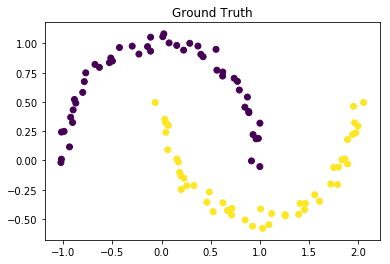

In [7]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sigma_sq = .01
n_clusters = 2
n_samples = 100
np.random.seed(1234)

dataset_collection = []
dataset_collection.append(datasets.make_circles(n_samples, factor = 0.5, noise = 0.05))
dataset_collection.append(datasets.make_moons(n_samples, noise = 0.05))
dataset_collection.append(datasets.make_blobs(n_samples, centers = 3, n_features = 2))

dataset, clusters = dataset_collection[1]

def plot_results(X, clusters, title):
    plt.title(title)    
    plt.scatter(X[:,0], X[:,1], c = clusters)
    plt.show()
    
plot_results(dataset, clusters, "Ground Truth")

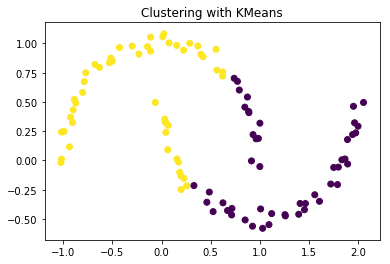

In [2]:
# try clustering with KMeans for comparision
km = KMeans(n_clusters)
km.fit(dataset)
y_pred = km.labels_

# plot results
plot_results(dataset, y_pred, "Clustering with KMeans")

In [3]:
from numpy.linalg import norm
from math import exp

# compute the affinity of samples X1, X2
def affinity_kernel(x1, x2):
    return exp(-(norm(x1 - x2) ** 2) / (2 * sigma_sq))

# construct affinity matrix
A = np.zeros((len(dataset), len(dataset)))
for i in range(len(dataset) - 1):
    for j in range(i + 1, len(dataset)):
        A[i, j] = affinity_kernel(dataset[i], dataset[j])
        A[j, i] = A[i, j]

# print affinity matrix
np.set_printoptions(precision = 2)
print(A)

[[0.00e+00 1.03e-03 1.63e-51 ... 1.34e-19 4.84e-76 1.37e-16]
 [1.03e-03 0.00e+00 1.05e-65 ... 1.30e-13 2.84e-81 4.45e-20]
 [1.63e-51 1.05e-65 0.00e+00 ... 5.25e-43 9.14e-13 6.51e-16]
 ...
 [1.34e-19 1.30e-13 5.25e-43 ... 0.00e+00 5.28e-38 1.72e-08]
 [4.84e-76 2.84e-81 9.14e-13 ... 5.28e-38 0.00e+00 7.95e-23]
 [1.37e-16 4.45e-20 6.51e-16 ... 1.72e-08 7.95e-23 0.00e+00]]


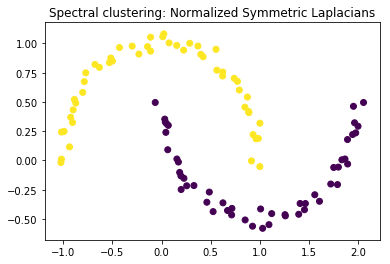

In [4]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from enum import Enum

class LaplaciansType(Enum):
        UNNORM = 1
        NORM_SYM = 2
        NORM_RW = 3

def get_laplacians(W, graph_type):
    # Construct diagonal degree matrix
    D = np.zeros(W.shape)
    for i in range(W.shape[0]):
        D[i, i] = np.sum(W[i, :])
        
    L = np.zeros(W.shape)
    I = np.matlib.identity(W.shape[0])
    
    if graph_type == LaplaciansType.UNNORM:
        L = D - W
    elif graph_type == LaplaciansType.NORM_SYM:
        D_inv_sq = np.sqrt(np.linalg.inv(D))
        L = I - D_inv_sq @ W @ D_inv_sq
    elif graph_type == LaplaciansType.NORM_RW:
        D_inv = np.linalg.inv(D)
        L = I - D_inv @ W
    
    return L

def spectral_clustering(weighted_graph, cluster_count, graph_type):
    W = weighted_graph
    K = cluster_count
        
    # Construct Laplacian Matrix:
    L = get_laplacians(W, graph_type)
    
    # Find the K first eigenvectors of L
    eigvals, eigvects = np.linalg.eigh(L)
    first_eigens = [i for i in range(K)]
    
    U = np.zeros((L.shape[0], K))
    U[:, :] = eigvects[:, first_eigens]
    
    if graph_type == LaplaciansType.NORM_SYM:
        # normalize new eigenvector-column-matrix
        U = (U.T / np.linalg.norm(U, axis = 1)).T
    
    # Finally, do clustering on reduced space using KMeans:
    km = KMeans(n_clusters = K, n_init = 20)
    km.fit(U)
    y_pred = km.labels_ #1 if x > 0 else 0 for x in T
    return y_pred

spectral_clusters = spectral_clustering(A, n_clusters, LaplaciansType.NORM_SYM)
plot_results(dataset, spectral_clusters, "Spectral clustering: Normalized Symmetric Laplacians")

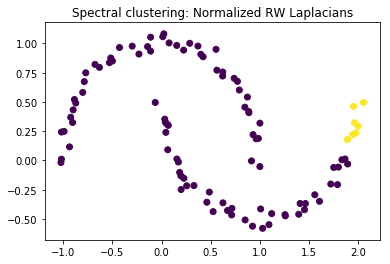

In [5]:
spectral_clusters = spectral_clustering(A, n_clusters, LaplaciansType.NORM_RW)
plot_results(dataset, spectral_clusters, "Spectral clustering: Normalized RW Laplacians")

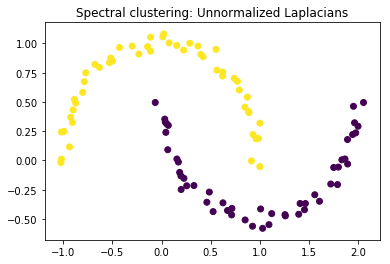

In [6]:
spectral_clusters = spectral_clustering(A, n_clusters, LaplaciansType.UNNORM)
plot_results(dataset, spectral_clusters, "Spectral clustering: Unnormalized Laplacians")